<a name='0'></a>

# A ConvNet for the 2020s

We previously have been implementing some of the remarkable computer vision papers. As far as you may have noticed, computer vision research community is [very and very vibrant](https://twitter.com/Jeande_d/status/1446468370182799364). 

In 2020&21, the researches in visual recognition community were mostly dominated by [Vision Transformers(ViT)](https://arxiv.org/abs/2010.11929). Introduced in 2020, the standard ViT achieved great results comparable to modern deep convolutional neural networks in image classification tasks, but it could not replace former backbone networks (like ResNet) in complex tasks(or downstream tasks) like object detection and image segmentation. Later, [Swin Transformer](https://arxiv.org/abs/2103.14030) demonstrated that self-attention can replace CNNs in almost all computer vision tasks by achieving state of the results on image classification, object detection and image segmentation.

The effort to replace CNNs is due to the [spatial inductive biases](https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/40864/MITCHELL-DISSERTATION-2017.pdf?sequence=1&isAllowed=y)(assuming that certain type of spatial structure is present in the image) by convolution. But the question is: can we let go of CNNs? Maybe yes, or maybe not. Let's see where it goes!

For now, let's just see the new wave of ConvNets: [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545), a modernized ResNet coined ConvNeXt that follow the design of visual transformers and achieve top-1 accuracy of 87.8% on ImageNet and outperformed Swin Transformer on COCO object detection and ADE20K segmentation, while maintaining the simplicity and efficiency of pure ConvNets!

What's in here:

* [Introduction](#1)
* [Modernizing ResNet RoadMap](#2)
* [ConvNeXt Architecture](#3)
* [ConvNeXt implementation](#4)
* [Final Notes](#5)
* [Reference Implementations](#6)

<a name='1'></a>

## 1. Introduction

In the last decade, particuraly in 2012, when AlexNet won ImageNet challenge, convolutional neural networks or CNNs became the prime mover of deep learning and computer vision. Since then, more and more efficient architectures such as Inception V3, ResNet, and EfficientNet demonstrated the potential performance of CNNs across wide range of computer vision tasks such as image classification, object detection, and image segmentation.

While CNNs were revolutionalizing the field of computer vision, transformers were doing the same things in Natural Language Processing(NLP), mainly replacing Recurrent Neural Networks(RNNs). Transformers went beyond NLP to achieving state of the arts results in computer vision and not just only image classicification, but also for object detection and image segmentation as well. 

As the paper noted, "the essence of convolution is not becoming irrelevant; rather, it remains much desired and has never faded. The only reason ConvNets appear to be losing steam is that (hierarchical) Transformers surpass them in many vision tasks, and the performance difference is usually attributed to the superior scaling behavior of Transformers, with multi-head self-attention being the key component. How do design decisions in Transformers impact ConvNets’ performance?" That's the question that the paper seeks to answer by modernizing the ResNet50 to ward the design of vision transformer.

<a name='2'></a>

## 2. Modernizing ResNet Roadmap

The central idea of the paper is to investigate and to follow the levels of designs of Swin Transformer while maintaining the simplicity of standard ConvNets such as ResNet. In other words, ConvNeXt seeks to imitate the design features that makes Swin Transformers great and apply them on standard ConvNets.

The authors present their full roadmap with clear and experimented results. Here we will review the high-level takes from what they found: 

* Their **baseline** was ResNet-50 trained on ImageNet with vision transformers training techniques. 
* They used the **Swin transformer training techniques** such as AdamW optimizer and different data augmentation techniques like [Mixup](https://paperswithcode.com/method/mixup), [CutMix](https://paperswithcode.com/method/cutmix), [randaugment](https://paperswithcode.com/method/randaugment), [random erasing](https://paperswithcode.com/method/random-erasing) and different regularization schemes such as [stochastic depth](https://paperswithcode.com/method/stochastic-depth) and [label smoothing](https://paperswithcode.com/method/label-smoothing).

* **Changing the stage compute ratio**: The orginal ResNet-50 used stage ratio of (3,4,6,3). Stage ratio are the number of resnet blocks in each stage. Learning from Swin Transformer that uses stage ratio of (1:1:3:1 and 1:1:9:1 for large transformers), ConvNeXt uses stage ratio of (3,3,9,3). That change improves accuracy and computation efficiency. 

* **Changing stem to `patchify`:** The stem block or input downsampling block of ResNet contains 7x7 convolution with strides of 2 followed by maxpool. Swin Transformer uses a patchify layer with a patch size of 4. ConvNeXt implements a patchify layer using 4x4, stride 4 convolution layer. That also improves the accuracy.

* **Using depthwise convolution**: Inspired by ResNeXt that used grouped convolution, ConvNeXt uses a 7x7 depthwise convolution in ConvNeXt blocks. Depthwise convolution is a special type of grouped convolution where the number of groups equal the number of channels. Depthwise convolutions have been previously used in notable architectures such as [MobileNet](https://arxiv.org/pdf/1704.04861v1.pdf) and Francois Chollet's [Xception](https://arxiv.org/abs/1610.02357). Using depthwise convolution effectively reduces the FLOPS(floating points) (and accuracy), but there is an arguments that it doesn't such as [this](https://twitter.com/giffmana/status/1481553232400949251) and [this](https://twitter.com/ChrSzegedy/status/1481578727242825728).


* **Using inverted bottlenecks blocks:** Every transformer block creates inverted block. ConvNeXt learnt from that and that resulted in improved accuracy and even fewer parameters/reduced network FLOPs. Below is the illustration of the inverted block.

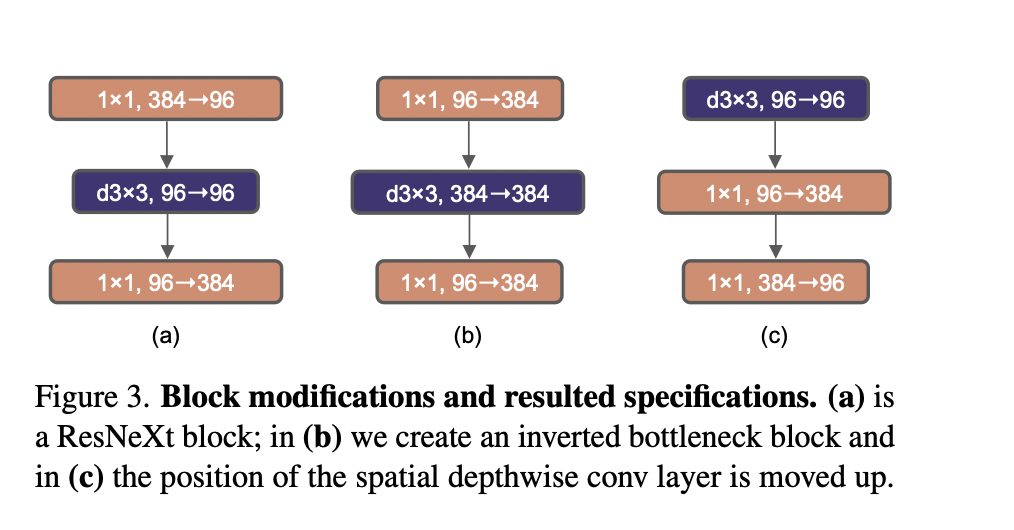

* **Replacing ReLU with GELU:** [GELU](https://arxiv.org/abs/1606.08415v4) standing for Gaussian Error Linear Unit has been used in Vision Transformers(ViT) and other transformer-based language models such as BERT and GPT-2. Replacing it with ReLU didn't change the accuracy but the author opted to use it since their mere goal was to mimic the design of vision transformers to CNNs in hope of improvement. Replacing ReLU with GeLU is trading the simplicity without a gain, Karpathy [said](https://twitter.com/karpathy/status/1481724509795221505?s=20).

* **Replacing batch normalization with layer normalization:** Batch normalization is an essential component of ConvNets because it helps the network to converge faster and reduces overfitting. But how batch normalization works is not clearly understood. Because layer normalization is mostly used in transformers, the authors decided to replace it with layer normalization but they only used one normalization layer in residual block.

* **Using fewer activation functions and fewer normalization layers:** Every convolution layer in ResNet's residual blocks was followed by normalization and activation layer. On the other hand, transformers use fewer activations functions and normalization layers. The authors also learned from transformers and used only one GELU activation between two pointwise convolutions(1x1 conv) and also used a single normalization layer before the first 1x1 conv in each residual block.

* **Using separate downsampling layers**: In ResNet, the spatial downsampling is achieved by the residual block at the start of each stage using 3x3 conv with stride 2 and a shortcut connection of 1x1 conv with stride of 2. Transformers uses a separate downsampling layer. ConvNeXt replicated that and rather than using ResNet downsampling strategy, it used a separate downsampling layers. The downsampling layers in ConvNeXt are layer normalization followed by normal 2x2 convolution with strides of 2 and are inserted between stages. The stem network(7x7 depthwise conv and layer normalization) comes above the first stage, but then between the all following stages, there are downsampling layers.

Below is the blocks comparison of ConvNeXt, ResNet and Swin transformers:

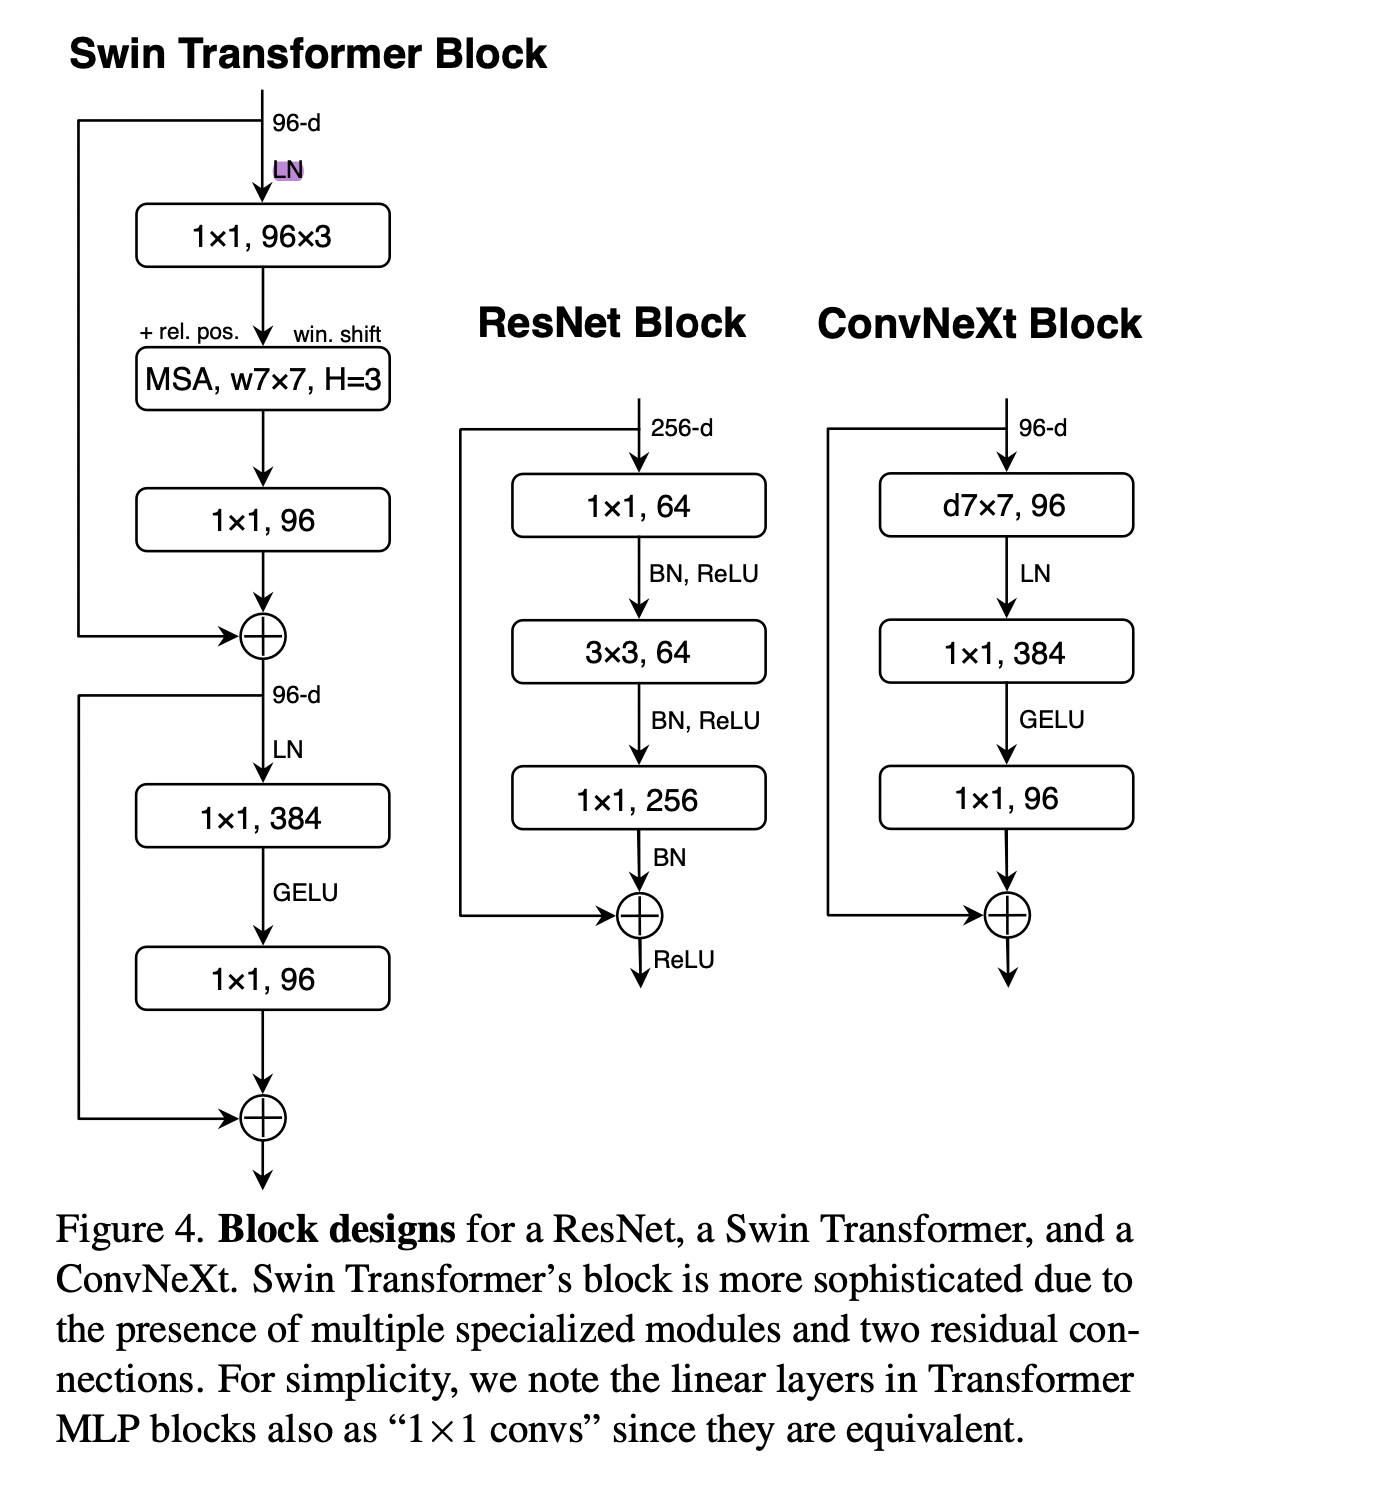

The above were the major things that ConvNeXt adapted from transformers. ConvNeXt, a modernized ResNet outperformed Swin transformers on ImageNet 1k classification with an accuracy of 82%. ConvNeXt has the same FLOPs, parameters count, throughput and same memory as Swin transformer. The special thing about ConvNeXt is that it's a pure ConvNet. It doesn't use special thing like attentions.

With that said, the authors concluded the design roadmap with the remarks that although ConvNeXt can outperform Swin Transformer on ImageNet 1K, vision transfomer scaling behavior is truly indistinguishible.

<a name='3'></a>

## 3. ConvNeXt Architecture

Below is the full details of the architecture of ConvNeXt.

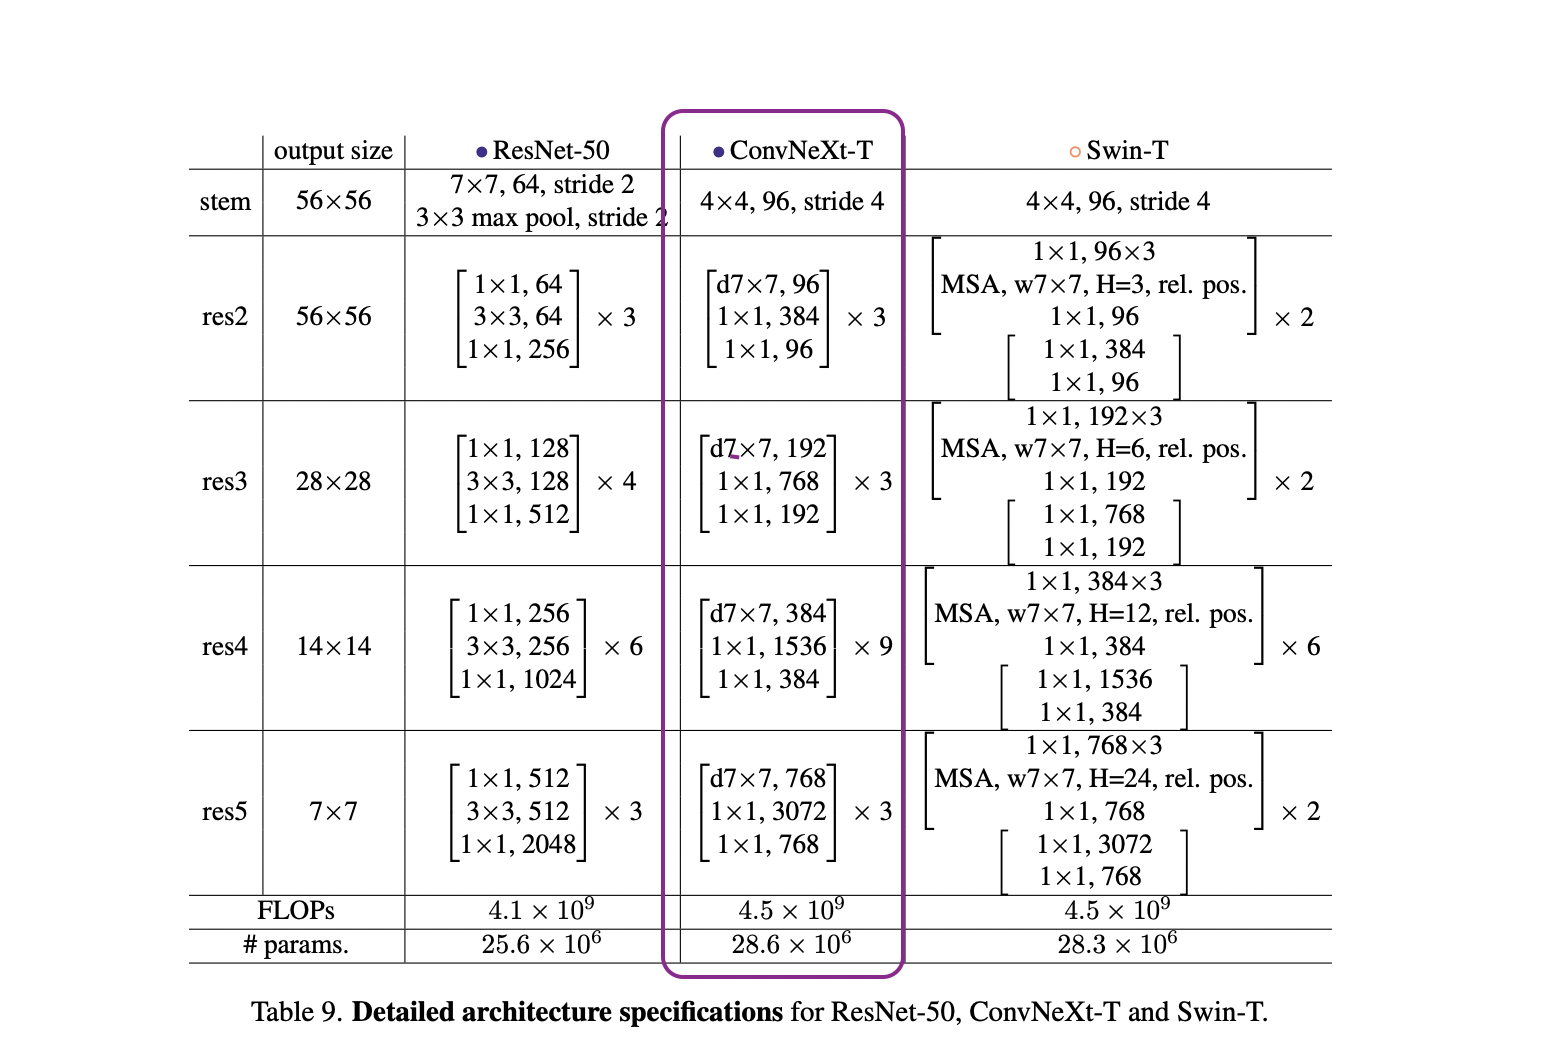

<a name='4'></a>

## 4. ConvNeXt Implementation

### Set Up

Let's install [TensorFlow Addons](https://github.com/tensorflow/addons) so that we can use some layers that are not in TensoFlow API yet. More precisely, we will use [Stochastic Depth](https://arxiv.org/abs/1603.09382) that randomly skip or drop layers in residual block during training.

In [2]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 32.0 MB/s 


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import tensorflow_addons as tfa

We are going to implement the full architecture of ConvNeXt using Keras Functional API. We will start with ConvNeXt block and then later build the full architecture.

### ConvNeXt Residual Block

In [3]:
def convnext_block(input, dim, drop_path=0.0):
  """
  ConvNeXt Block

  Input Parameters:

  input: input tensor
  dim: Number of filters/channels
  drop_path: Set to 0 by default
  ----------------------

  About the block:
    - 7x7 depthwise conv(can be implemented from Conv2D, no of groups = no of filters)
    - 2 1x1 convs or pointwise layers are equivalent to dense layers(or fully connected layer) operating independently on each channel
    - The number of channels in the first 1x1 conv is 4 times the input dimension.
    - The channels for the last 1x1 conv are similar to input channels. See the block.
    - Layer normalization layer comes before the first 1x1 conv
    - GELU layer is inserted between two 1x1 convs
    - There is a direct shortcut from the input of the block to the output
  """
  shortcurt = input #shortcut connection
  x = layers.Conv2D(filters=dim, kernel_size=7, padding='same', groups=dim)(input)
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Dense(4 * dim)(x)
  x = layers.Activation('gelu')(x)
  x = layers.Dense(dim)(x)
  
  #Stochastic depth
  drop_depth = tfa.layers.StochasticDepth(drop_path) if drop_path > 0.0 else layers.Activation("linear")

  output = layers.Add()([shortcurt, drop_depth(x)])

  return output

### Stem and Downsampling Block

The stem of the network is made of 4x4 convolution layer with stride 4 followed by a layer normalization layer. The stem network comes at the beginning of ConvNeXt.

Downsampling layers are layer normalization layer and 2x2 convolution layer. Downsampling layers are used for reducing the spatial resolution and are inserted between ConvNeXt stages.

In [4]:
def stem(input, dim):

  x = layers.Conv2D(filters=dim, kernel_size=4, strides=4)(input)
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  return x

In [5]:
def downsampling_layers(input, dim):

  x = layers.LayerNormalization(epsilon=1e-6)(input)
  x = layers.Conv2D(filters=dim, kernel_size=2, strides=2)(x)

  return x

### Building the Whole ConvNeXt Network

In [6]:
def convnext_model(input_shape=(224, 224, 3), dims=[96, 192, 384, 768], num_classes=1000):

  input = layers.Input(input_shape)

  # stem
  x = stem(input, dims[0])

  # Convnext stage 1 x3, dim[0] = 96
  for _ in range(3):
    x = convnext_block(x, dims[0])

  # Downsampling layers + stage 2 x3, dim[1] = 192
  x = downsampling_layers(x, dims[1])
  for _ in range(3):
    x = convnext_block(x, dims[1])

  # Downsampling layers + stage 3 x9, dim[2] = 384
  x = downsampling_layers(x, dims[2])
  for _ in range(9):
    x = convnext_block(x, dims[2])

  # Downsampling layers + stage 4 x3, dim[3] = 768
  x = downsampling_layers(x, dims[3])
  for _ in range(3):
    x = convnext_block(x, dims[3])
    
  # Classification head: Global average pool + layer norm + fully connected layer
  x = layers.GlobalAvgPool2D()(x)
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  output = layers.Dense(units=num_classes, activation='softmax')(x)

  model = keras.Model(input, output, name='ConvNeXt')

  return model

Let's now see the model summary.

In [7]:
convnext = convnext_model()
convnext.summary()

Model: "ConvNeXt"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 96)   4704        ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 56, 56, 96)  192         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

ConvNeXt has 29M parameters for the input image of (224,224,3) size. Rounding up `28,582, 504`, it's pretty close to the reported parameters count.

We can also plot the ConvNeXt model we just built with Keras model plotting util.

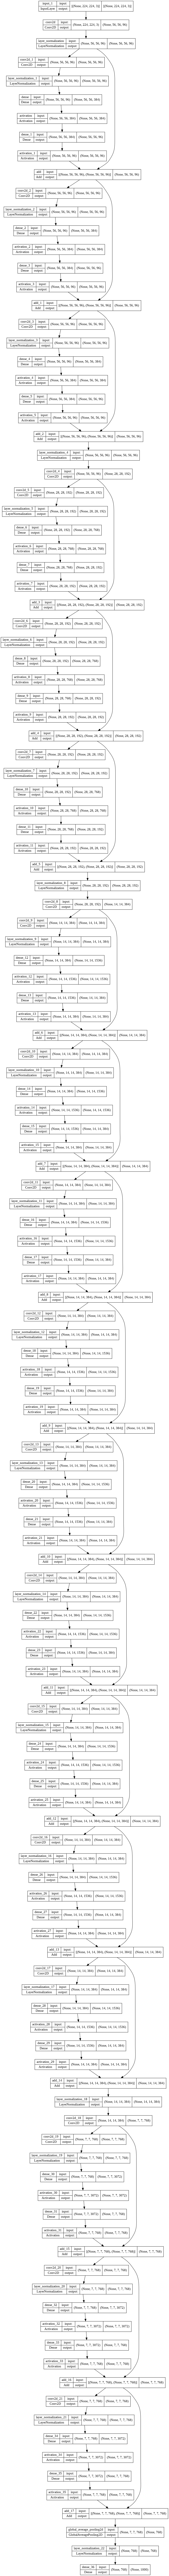

In [9]:
utils.plot_model(convnext, show_shapes=True)

<a name='5'></a>

## 5. Final Notes

The essence of ConvNeXt is showing that convolutions are not dead and with further studies, they can keep to be the prime mover of computer vision. 

There are several versions of ConvNeXt that differs in number of channels C and the number of blocks B in each stage. Just like ResNet and Swin Transformers, the number of channels double at each new stage. Below are the ConvNeXt versions:

- ConvNeXt-T: `C = (96, 192, 384, 768)`, `B = (3, 3, 9, 3)` (what we implemented).

- ConvNeXt-S: `C = (96, 192, 384, 768)`, `B = (3, 3, 27, 3)`

- ConvNeXt-B: `C = (128, 256, 512, 1024)`, `B = (3, 3, 27, 3)`

- ConvNeXt-L: `C = (192, 384, 768, 1536)`, `B = (3, 3, 27, 3)`

- ConvNeXt-XL: `C = (256, 512, 1024, 2048)`, `B = (3, 3, 27, 3)`

As you can see, ConvNeXt is simple to finetune as the whole network is fully convolutional. You only just need to change the channels C and  number of blocks B in stages.

ConvNeXt also achieved state of the art results on computer vision downstream tasks such as object detection and semantic segmentation. 

Per the paper, the mere goal of ConvNeXt was to modernize ResNet with recent Visual Transformers designs and training techniques. It demonstrated excellent results on image classification, object detection and semantic segmentation. As the authors concluded, "***ConvNeXt may be more suited for certain tasks, while Transformers may be more flexible for others. A case in point is multi-modal learning, in which a cross-attention module may be preferable for modeling feature interactions across many modalities.***"

<a name='6'></a>

## 6. Reference Implementations and Further Learning

* [ConvNeXt Official Implementation - PyTorch](https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py): 
* [ConvNeXt-TF Implementation by Sayak's Paul - TensorFlow/Keras](https://github.com/sayakpaul/ConvNeXt-TF)
* [ConvNeXt paper](https://arxiv.org/abs/2201.03545)
* [ConvNeXt Demo - HuggingFace](https://huggingface.co/spaces/akhaliq/convnext)

### [BACK TO TOP](#0)